In [6]:
#Import all the libraries

import numpy as np
import heapq
import matplotlib.pyplot as plt
import scipy.stats as sts
import random




#Code modified from session 2.1 (M/G/1 queue), modified to include manager and more than one queue

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    
    Attributes
    ----------
    timestamp : float
        The time at which the event should run.
    function : callable
        The function to call when running the event.
    args : tuple
        The positional arguments to pass to the function.
    kwargs : dict
        The keyword arguments to pass to the function.

    Methods
    -------
    __lt__(self, other)
        Compare two events based on their timestamp.
    run(self, schedule)
        Run the event by calling the function with the arguments and keyword


    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        your docstring
        Parameters
        ----------
        other
            <include your description here>
        
        Returns
        -------
        bool
            <include your description here>
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        your docstring
        Parameters
        ----------
        schedule
            <include your description here>
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    
    Attributes
    ----------
    now : float
        The time at which the last event was run.
    priority_queue : list
        The priority queue of events.

    Methods
    -------
    add_event_at(self, timestamp, function, *args, **kwargs)
        Add an event to the schedule at a specific time.
    add_event_after(self, interval, function, *args, **kwargs)
        Add an event to the schedule after a specific interval.
    next_event_time(self)
        Return the time at which the next event will run.
    run_next_event(self)
        Run the next event in the schedule.
    __repr__(self)
        Return a string representation of the schedule.
    print_events(self)
        Print the schedule and the events in the queue.


    '''
    
    def __init__(self):
        self.now = 0  
        self.priority_queue = []  
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        '''
        your docstring
        Parameters
        ----------
        <include your list and description here>
        
        Returns
        -------
        <include your list and description here>
        '''
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        '''
        your docstring
        Parameters
        ----------
        <include your list and description here>
        
        Returns
        -------
        <include your list and description here>
        '''
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        '''
        your docstring
        Parameters
        ----------
        <include your list and description here>
        
        Returns
        -------
        <include your list and description here>
        '''
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now}min ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'  ⏱ {event.timestamp}min: {event.function.__name__}')
    
    def time(self):
        # Convert time from float to hours and minutes
        hours = int(self.now // 60)
        minutes = int(self.now % 60)
        return f'{str.zfill(str(hours), 2)}:{str.zfill(str(minutes), 2)}'

In [7]:

#Add a MGC class to simulate
class Customer:
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time
        self.waiting_time = 0
        self.service_time = 0

class Queue_MGC:
    def __init__(self, service_distribution, queue_id, manager = None, log_events = True):
        self.queue_id = queue_id
        self.service_distribution = service_distribution
        self.manager = manager
        self.queue = []
        self.customers = []
        self.busy = False
        self.max_queue_length = 0
        self.log_events = log_events
    
    def __lt__(self, other):
        return len(self.queue) + self.busy < len(other.queue) + other.busy

    def __len__(self):
        return len(self.queue)
        
    def add_customer(self, schedule, customer):
        #add customer to the queue
        self.queue.append(customer)
        self.max_queue_length = max(self.max_queue_length, len(self.queue))
        if self.log_events:
            print(
                f'{schedule.time()}: Add customer to queue {self.queue_id}  '
                f'Queue length: {len(self.queue)}')

        self.customers.append(customer)
        #if the queue is not busy, start serving the customer
        if not self.busy:
            schedule.add_event_after(0, self.start_service)
        
    def start_service(self, schedule):
        #start serving the customer
        self.busy = True
        customer = self.queue.pop(0)
        customer.waiting_time += schedule.now - customer.arrival_time
        if self.log_events:
            print(
                f'{schedule.time()}: Start serving customer in queue {self.queue_id}  '
                f'Queue length: {len(self.queue)}')
        service_time = self.service_distribution.rvs()
        customer.service_time += service_time
        schedule.add_event_after(service_time, self.end_service, customer)

    def end_service(self, schedule, customer):
        #end serving the customer
        self.busy = False
        if self.log_events:
            print(
                f'{schedule.time()}: End serving customer in queue {self.queue_id}  '
                f'Queue length: {len(self.queue)}')
        # Probability of the manager being called
        if self.queue_id != 'Manager' and random.random() < 0.05:
            schedule.add_event_after(0, self.manager.add_customer, customer)
        #if there are more customers in the queue, start serving the next customer
        if len(self.queue) > 0:
            schedule.add_event_after(0, self.start_service)

            
class Manager(Queue_MGC):
    def __init__(self, service_distribution, log_events=True):
        super().__init__(service_distribution, queue_id='Manager', log_events=log_events)


#add the manager to teh grocery store class
class GroceryStore_MGC:
    def __init__(self, arrival_distribution, service_distribution, manager_distribution, queue_count, store_open = 540, store_close = 1200, log_events = True):
        self.manager = Manager(manager_distribution, log_events)
        if queue_count > 10:
            raise ValueError('The maximum number of queues is 10')
        self.queues = [Queue_MGC(service_distribution, queue_id=i, manager=self.manager, log_events=log_events) for i in range(queue_count)]
        self.arrival_distribution = arrival_distribution
        self.store_open = store_open
        self.store_close = store_close
        self.log_events = log_events

    def open_store(self, schedule):
        if self.log_events:
            print(f'Store opens at {schedule.time()}')
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def close_store(self, schedule):
        if self.log_events:
            print(f'Store closes at {schedule.time()}')

    def add_customer(self, schedule):
        # Check if the store is still open
        if schedule.now >= self.store_close:
            return

        # Add this customer to the queue
        customer = Customer(arrival_time = schedule.now)

        # Find the shortest queues and pick one at random
        shortest_queues = [queue for queue in self.queues if len(queue) == len(min(self.queues))]
        queue = random.choice(shortest_queues)
        queue.add_customer(schedule, customer)

        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the store opens and closes
        schedule.add_event_after(
            self.store_open,
            self.open_store)
        schedule.add_event_after(
            self.store_close,
            self.close_store)
        
        # Run the simulation
        while schedule.priority_queue:
            schedule.run_next_event()
        

def run_simulation(arrival_distribution, service_distribution, manager_distribution, queue_count, log_events):
    schedule = Schedule()
    grocery_store = GroceryStore_MGC(arrival_distribution, service_distribution, manager_distribution, queue_count, log_events=log_events)
    grocery_store.run(schedule)
    return grocery_store, schedule
        




In [8]:
arrival_distribution = sts.expon(scale=1)
service_distribution = sts.norm(loc=3, scale=1)
manager_distribution = sts.norm(loc=5, scale=2)
queue_count = 4
grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=queue_count, log_events=True)
print(f'🧍🏾‍♀️ There are {[len(queue) for queue in grocery_store.queues]} people in the queue')
print(f'🧍🏾‍♀️ There are {len(grocery_store.manager)} people in the manager queue')
# print(grocery_store.queues[0].waiting_times)
# print(len(grocery_store.customers))
# print(grocery_store.customers[1].waiting_time)
# print(grocery_store.customers[0].service_time)
print(f'🧍🏾‍♀️ The average waiting times for the queues are {[np.mean([customer.waiting_time for customer in queue.customers]) for queue in grocery_store.queues]}')
print(f'🧍🏾‍♀️ The average service times for the queues are {[np.mean([customer.service_time for customer in queue.customers]) for queue in grocery_store.queues]}')
print(f'🧍🏾‍♀️ The standard deviation of the service times for the queues are {[np.std([customer.service_time for customer in queue.customers]) for queue in grocery_store.queues]}')
print(f'🧍🏾‍♀️ The arrival rates for the queues are {[len(queue.customers)/(grocery_store.store_close - grocery_store.store_open) for queue in grocery_store.queues]}')
# print(f'🧍🏾‍♀️ The average waiting time for the manager is {np.mean([customer.waiting_time for customer in grocery_store.manager.customers])}')
# print(f'🧍🏾‍♀️ The average service time for the manager is {np.mean([customer.service_time for customer in grocery_store.manager.customers])}')



Store opens at 09:00
09:00: Add customer to queue 2  Queue length: 1
09:00: Start serving customer in queue 2  Queue length: 0
09:00: Add customer to queue 0  Queue length: 1
09:00: Start serving customer in queue 0  Queue length: 0
09:01: Add customer to queue 3  Queue length: 1
09:01: Start serving customer in queue 3  Queue length: 0
09:02: Add customer to queue 3  Queue length: 1
09:02: Add customer to queue 1  Queue length: 1
09:02: Start serving customer in queue 1  Queue length: 0
09:02: Add customer to queue 2  Queue length: 1
09:03: End serving customer in queue 0  Queue length: 0
09:04: Add customer to queue 0  Queue length: 1
09:04: Start serving customer in queue 0  Queue length: 0
09:04: Add customer to queue 0  Queue length: 1
09:05: End serving customer in queue 3  Queue length: 1
09:05: Start serving customer in queue 3  Queue length: 0
09:05: End serving customer in queue 2  Queue length: 1
09:05: Start serving customer in queue 2  Queue length: 0
09:06: End serving cu

100%|██████████| 10/10 [01:10<00:00,  7.09s/it]


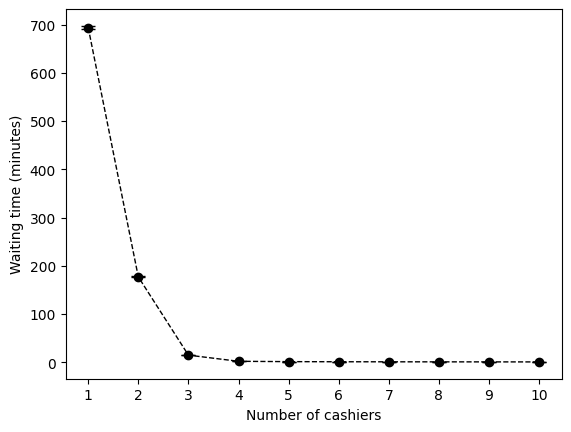

In [12]:
from tqdm import tqdm

cashiers = [i for i in range(1, 11)]
trials = 100

waiting_times_mean = []
waiting_times_std = []

for cashier_count in tqdm(cashiers):    
    waiting_times = []
    for trial in range(trials):
        grocery_store, _ = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        for queue in grocery_store.queues:
            waiting_times = waiting_times + [customer.waiting_time for customer in queue.customers]
    waiting_times_mean.append(np.mean(waiting_times))
    waiting_times_std.append(1.96*sts.sem(waiting_times))

plt.errorbar(cashiers, waiting_times_mean, waiting_times_std, marker='o', color = 'black', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Number of cashiers')
plt.xticks(cashiers)
plt.ylabel('Waiting time (minutes)')
plt.show()
    





In [178]:
print(waiting_times_mean)
print(waiting_times_std)

[690.9685527668138, 175.35118860673285, 14.571455668515526, 1.9299211296057488, 1.261904967612257, 1.02479500663561, 0.9159874551225913, 0.8000992710221364, 0.7422658378887987, 0.691031888017805]
[3.3225152861322944, 0.8617591361232053, 0.11302181878679314, 0.018044857742704104, 0.014113352095876117, 0.012857696113622816, 0.012926995019244056, 0.012021788335726665, 0.011776998443717261, 0.011794861769061644]


10
10


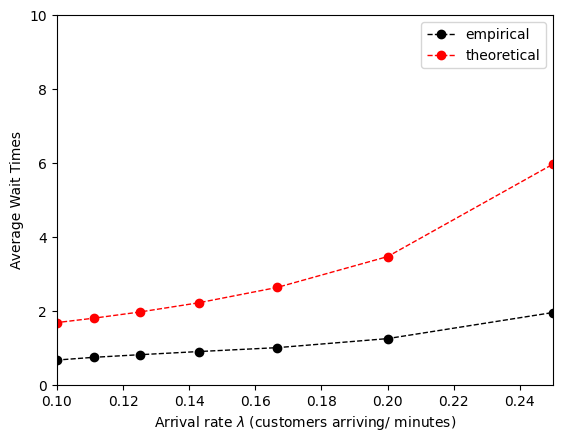

In [106]:
def theoretical_avg_wait_time(lamda, tau=3, sigma=1): 
    rho = lamda * tau 

    l = 1/20
    manager_tau = 5
    manager_rho = l * manager_tau
    manager_sigma = 2

    manager_avg_wait_time = (manager_rho*manager_tau / (2*(1-manager_rho))) * (1 + manager_sigma**2 / manager_tau**2)
    #print(manager_avg_wait_time)
    #print(rho)
    return (rho*tau / (2*(1-rho))) * (1 + (sigma /tau)**2) + manager_avg_wait_time

theoretical_wait_times = []
x_arrival_rate = []
for i in cashiers: 
    if i == 3: 
        # Theoretical result for 3 cashiers is not defined
        theoretical_wait_times.append(0)
        x_arrival_rate.append(0.33)
        continue
    lamda = 1/i
    x_arrival_rate.append(lamda)
    theoretical_wait_times.append(theoretical_avg_wait_time(lamda))

plt.figure()

#plt.title('Average Wait Times for different Arrival Rates empirical and theoretical results')
plt.xlabel('Arrival rate $\lambda$ (customers arriving/ minutes)')
plt.ylabel('Average Wait Times')

print(len(waiting_times_mean))
print(len(x_arrival_rate))
#print(len(theoretical_wait_times))
plt.plot(x_arrival_rate, waiting_times_mean, color='black', marker='o', linestyle='--', linewidth=1, label='empirical')
plt.plot(x_arrival_rate, theoretical_wait_times, color='red', marker='o', linestyle='--', linewidth=1, label='theoretical')
plt.xlim(0.1, 0.25)
plt.ylim(0,10) 
plt.legend()
plt.show()

0.9666666666666667
3.0
0.9666666666666667
1.5
0.9666666666666667
0.75
0.9666666666666667
0.6000000000000001
0.9666666666666667
0.5
0.9666666666666667
0.42857142857142855
0.9666666666666667
0.375
0.9666666666666667
0.3333333333333333
0.9666666666666667
0.30000000000000004


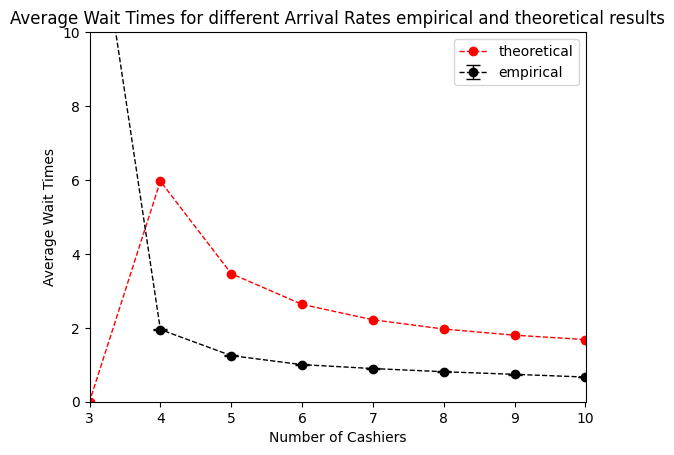

In [67]:
def theoretical_avg_wait_time(lamda, tau=3, sigma=1): 
    rho = lamda * tau 

    l = 1/20
    manager_tau = 5
    manager_rho = l * manager_tau
    manager_sigma = 2

    manager_avg_wait_time = (manager_rho*manager_tau / (2*(1-manager_rho))) * (1 + manager_sigma**2 / manager_tau**2)
    print(manager_avg_wait_time)
    print(rho)
    return (rho*tau / (2*(1-rho))) * (1 + (sigma /tau)**2) + manager_avg_wait_time

theoretical_wait_times = []
for i in cashiers: 
    if i == 3: 
        # Theoretical result for 3 cashiers is not defined
        theoretical_wait_times.append(0)
        continue
    lamda = 1/i
    theoretical_wait_times.append(theoretical_avg_wait_time(lamda))

plt.figure()

plt.title('Average Wait Times for different Arrival Rates empirical and theoretical results')
plt.xlabel('Number of Cashiers')
plt.ylabel('Average Wait Times')


plt.errorbar(cashiers, waiting_times_mean, waiting_times_std, color='black', marker='o', capsize=5, linestyle='--', 
             linewidth=1, label='empirical')
plt.plot(cashiers, theoretical_wait_times, color='red', marker='o', linestyle='--', linewidth=1, label='theoretical')
plt.xlim(3, 10)
plt.ylim(0,10) 
plt.legend()
plt.show()

100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


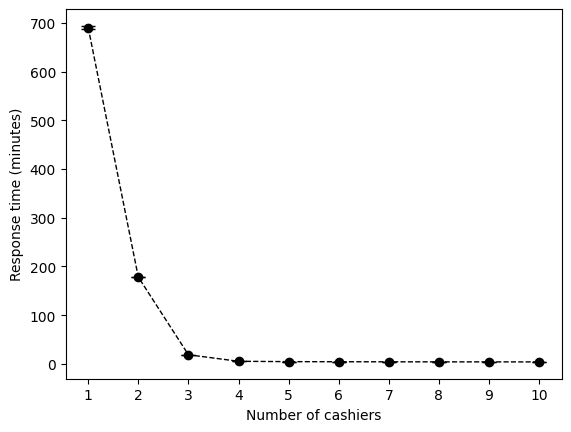

In [69]:
# Average customer response time, defined as the waiting time added by the service time.
# This is the metric we want to minimize.
response_times_mean = []
response_times_std = []

for cashier_count in tqdm(cashiers):
    response_times = []
    for trial in range(trials):
        grocery_store, _ = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        for queue in grocery_store.queues:
            response_times = response_times + [customer.waiting_time + customer.service_time for customer in queue.customers]
    response_times_mean.append(np.mean(response_times))
    response_times_std.append(1.96*sts.sem(response_times))

plt.errorbar(cashiers, response_times_mean, response_times_std, marker='o', color = 'black', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Number of cashiers')
plt.xticks(cashiers)
plt.ylabel('Response time (minutes)')
plt.show()



In [71]:
# Maximum queue length during a day, given the number of cashiers employed.
queue_lengths_mean = []
queue_lengths_std = []

for cashier_count in tqdm(cashiers):
    queue_lengths = []
    for trial in range(trials):
        grocery_store, _ = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        queue_lengths.append(max([queue.max_queue_length for queue in grocery_store.queues]))
    queue_lengths_mean.append(np.mean(queue_lengths))
    queue_lengths_std.append(sts.sem(queue_lengths))

100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


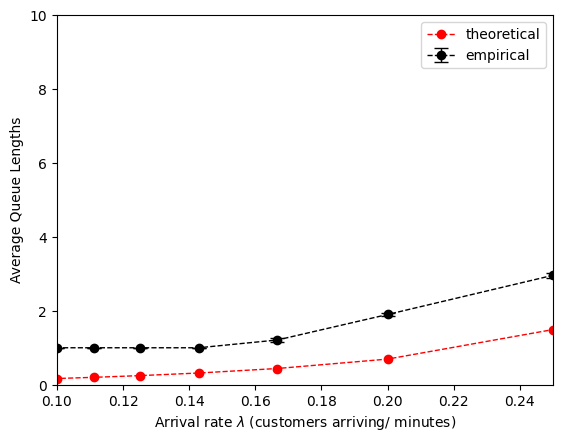

In [105]:
def theoretical_avg_queue_length(lmd, tau=3, sigma=1): 
    rho = lmd * tau
    return lmd*theoretical_avg_wait_time(lmd, tau, sigma)

theoretical_avg_queue_lengths = []
x_lmd = [] 
for i in range(1,11):  
    lmd = 1/i
    if i == 3: 
        # Theoretical result for 3 cashiers is not defined
        theoretical_avg_queue_lengths.append(0)
        x_lmd.append(lmd)
        continue
    x_lmd.append(lmd)
    theoretical_avg_queue_lengths.append(theoretical_avg_queue_length(lmd)) 

plt.figure()

#plt.title('Average Queue Lengths for different Arrival Rates empirical and theoretical results')
plt.xlabel('Arrival rate $\lambda$ (customers arriving/ minutes)')
plt.ylabel('Average Queue Lengths')


plt.errorbar(x_lmd, queue_lengths_mean, queue_lengths_std, color='black', marker='o', capsize=5, linestyle='--', 
             linewidth=1, label='empirical')
plt.plot(x_lmd, theoretical_avg_queue_lengths, color='red', marker='o', linestyle='--', linewidth=1, label='theoretical')
plt.ylim(0,10)
plt.xlim(0.1, 0.25)
plt.legend()
plt.show()

0.9666666666666667
3.0
0.9666666666666667
1.5
0.9666666666666667
0.75
0.9666666666666667
0.6000000000000001
0.9666666666666667
0.5
0.9666666666666667
0.42857142857142855
0.9666666666666667
0.375
0.9666666666666667
0.3333333333333333
0.9666666666666667
0.30000000000000004


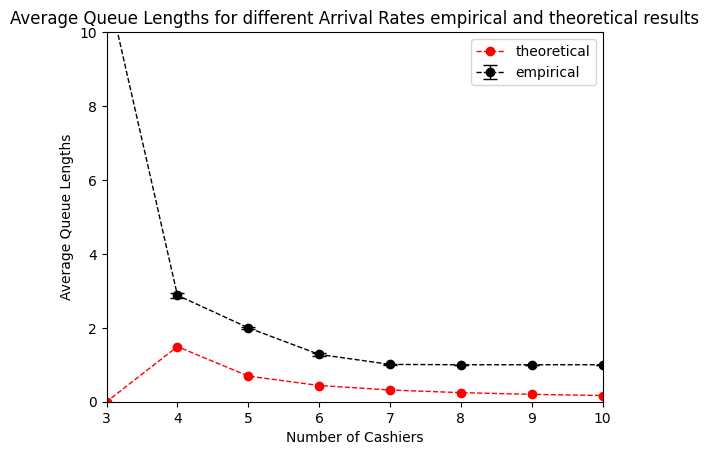

In [184]:
def theoretical_avg_queue_length(lmd, tau=3, sigma=1): 
    rho = lmd * tau
    return lmd*theoretical_avg_wait_time(lmd, tau, sigma)

theoretical_avg_queue_lengths = [] 
for i in range(1,11):  
    lmd = 1/i
    if i == 3: 
        # Theoretical result for 3 cashiers is not defined
        theoretical_avg_queue_lengths.append(0)
        continue
    theoretical_avg_queue_lengths.append(theoretical_avg_queue_length(lmd)) 

plt.figure()

plt.title('Average Queue Lengths for different Arrival Rates empirical and theoretical results')
plt.xlabel('Number of Cashiers')
plt.ylabel('Average Queue Lengths')


plt.errorbar(cashiers, queue_lengths_mean, queue_lengths_std, color='black', marker='o', capsize=5, linestyle='--', 
             linewidth=1, label='empirical')
plt.plot(cashiers, theoretical_avg_queue_lengths, color='red', marker='o', linestyle='--', linewidth=1, label='theoretical')
plt.ylim(0,10)
plt.xlim(3, 10)
plt.legend()
plt.show()


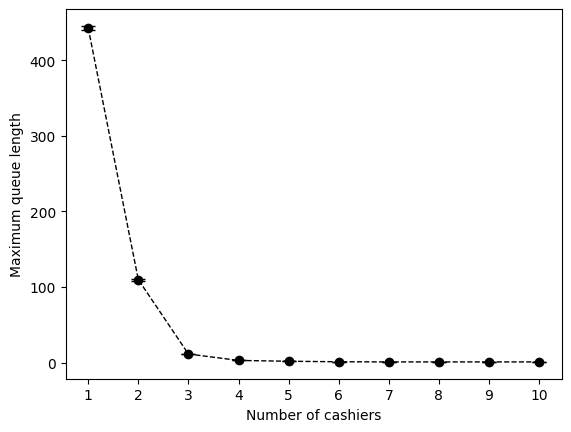

In [73]:
plt.errorbar(cashiers, queue_lengths_mean, queue_lengths_std, marker='o', color = 'black', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Number of cashiers')
plt.xticks(cashiers)
plt.ylabel('Maximum queue length')
plt.show()

100%|██████████| 10/10 [01:07<00:00,  6.78s/it]


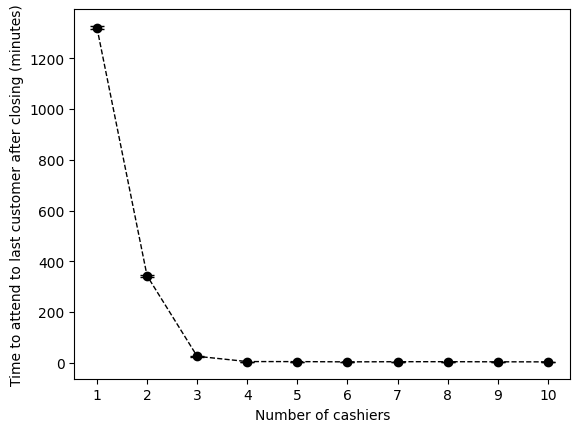

In [72]:
# Average time after the store closes till the last customer leaves.
# This is the metric we want to minimize.
last_customer_times_mean = []
last_customer_times_std = []

for cashier_count in tqdm(cashiers):
    last_customer_times = []
    for trial in range(trials):
        grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        last_customer_times.append(schedule.now - grocery_store.store_close)
    last_customer_times_mean.append(np.mean(last_customer_times))
    last_customer_times_std.append(sts.sem(last_customer_times))

plt.errorbar(cashiers, last_customer_times_mean, last_customer_times_std, marker='o', color = 'black', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Number of cashiers')
plt.xticks(cashiers)
plt.ylabel('Time to attend to last customer after closing (minutes)')
plt.show()

In [34]:
l = 1/4
tau = 3
rho = l * tau
sigma = 1

print("Theoretical mean waiting time:", (rho * tau / (2 * (1 - rho))) * (1 + (sigma/tau)**2))

Theoretical mean waiting time: 5.0


In [24]:
l = 1/20
tau = 5
rho = l * tau
sigma = 2

print("Theoretical mean waiting time:", (rho * tau / (2 * (1 - rho))) * (1 + (sigma/tau)**2))

Theoretical mean waiting time: 0.9666666666666668


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


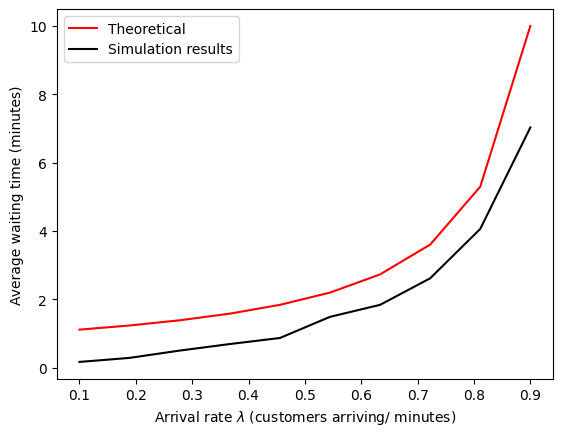

In [107]:
# Try with an M/M/1 queue (because we are using a general equation the results should be teh same if we cahnge the distribution)



def comperison_wait_time():

    #arrival_distribution = sts.expon(scale=1/l)
    
    val_la = np.linspace(0.1, 0.9, 10)
    #waiting_times_mean = []
    theoretical = []
    empirical = []

    for l in tqdm(val_la):
        waiting_times = []
        for trial in range(30):
            grocery_store, _ = run_simulation(arrival_distribution= sts.expon(scale=1/l), service_distribution= sts.expon(scale=1), manager_distribution=manager_distribution, queue_count=1, log_events=False)
            for queue in grocery_store.queues:
                waiting_times = waiting_times + [customer.waiting_time for customer in queue.customers]
            #waiting_times = waiting_times + grocery_store.manager.waiting_times
        empirical.append(np.mean(waiting_times))
        theoretical.append(1 + l/(1-l))

    plt.plot(val_la, theoretical, color = 'red', label = r'Theoretical')
    plt.plot(val_la, empirical, color = 'black', label = r'Simulation results')
    plt.xlabel(r'Arrival rate $\lambda$ (customers arriving/ minutes)')
    plt.ylabel(r'Average waiting time (minutes)')
    plt.legend()
    plt.show()

comperison_wait_time()